#**False Data Injection Attack Detection Using Convolutional Neural Networks**
Here is the implementation of a Convolutional Neural Network (CNN) to detect False Data Injection Attacks (FDIAs) in Cyber-Physical Power Systems (CPPS). FDIAs pose critical risks to power grid stability by manipulating measurement data to bypass traditional detection mechanisms. CNNs excel at identifying spatial patterns in high-dimensional cyber-physical data, making them ideal for analyzing the complex correlations between grid measurements and network traffic



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization,Conv1D,MaxPooling1D,Flatten,LeakyReLU
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix, f1_score
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
normal_raw = pd.read_csv('gdrive/My Drive/FDIA Detection Using ML Methods/IEE118_normal_results_15k.csv')
attack_raw = pd.read_csv('gdrive/My Drive/FDIA Detection Using ML Methods/IEE118_attack_results_15k.csv')

normal_raw.describe()

combined_df = pd.concat([normal_raw, attack_raw], axis=0, ignore_index=True)

df = combined_df
combined_df.describe()

,1,2,3,4,5,6,7,8,9,10,...,346,347,348,349,350,351,352,353,354,355
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.955157,0.970407,0.968010,0.996983,1.001323,0.989759,0.989248,1.016870,1.043026,1.051137,...,39.214284,0.028271,68.265169,6.056289,8.051394,22.129862,184.753928,20.102261,33.132794,0.500000
std,0.191250,0.188326,0.184085,0.188234,0.183715,0.189184,0.191944,0.189101,0.190961,0.184745,...,6.354712,0.445949,9.816918,0.922059,1.089062,3.492958,26.175545,2.906437,4.568181,0.500008
min,-3.442669,-2.047495,-3.812594,-1.926533,-3.054991,-2.065296,-2.126737,-2.696631,-2.361348,-2.162041,...,0.000000,-0.417522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.920790,0.937125,0.933810,0.964293,0.967608,0.955760,0.955535,0.981209,1.009369,1.016354,...,38.966462,-0.034295,67.965635,5.965637,7.966054,21.965784,183.966215,19.965519,32.965695,0.000000
50%,0.954953,0.971333,0.968299,0.998951,1.001385,0.990079,0.989402,1.015288,1.043030,1.050168,...,39.000605,0.000130,67.999844,6.000148,8.000250,22.000340,184.000082,19.999803,32.999857,0.500000
75%,0.989364,1.005660,1.001952,1.032346,1.035612,1.024446,1.023756,1.048839,1.076870,1.084159,...,39.034181,0.034156,68.034064,6.034388,8.034518,22.034182,184.033937,20.033506,33.034153,1.000000
max,4.086837,4.736227,5.333843,3.996384,6.624224,4.050982,5.008182,5.192250,3.930148,4.864556,...,432.703619,10.000000,282.248616,47.432481,68.859187,204.580331,722.485066,83.132996,225.739342,1.000000


In [ ]:
df2 = df
#df2 = df2.sample(frac=0.5)
data = np.array(df2)
# data = data[:,2:]
data_X = data[:,:-1]
data_Y = data[:,-1]
data_Y = data_Y.astype('int')
print(np.unique(data_Y,return_counts=True))
data[0:5]

(array([0, 1]), array([15000, 15000]))


array([[ 0.89293374,  0.87030927,  0.97849722, ..., 19.97840335,
        32.97479688,  0.        ],
       [ 1.03544168,  0.96344   ,  0.92478233, ..., 19.9763197 ,
        32.96527437,  0.        ],
       [ 0.88412629,  0.99019775,  0.91460271, ..., 19.97348705,
        32.96627457,  0.        ],
       [ 0.92476425,  0.95219227,  0.89901061, ..., 19.98290856,
        32.98876214,  0.        ],
       [ 0.96819346,  0.96969975,  0.91663812, ..., 20.02706412,
        32.91512267,  0.        ]])

In [ ]:
scaler = MinMaxScaler()
data_X = scaler.fit_transform(data_X)

In [ ]:
data_X.shape

(30000, 354)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(data_X,data_Y,test_size=0.2,random_state=42)

In [ ]:
def dyn_weighted_bincrossentropy(true, pred):
    """
    Calculates weighted binary cross entropy. The weights are determined dynamically
    by the balance of each category. This weight is calculated for each batch.

    The weights are calculted by determining the number of 'pos' and 'neg' classes
    in the true labels, then dividing by the number of total predictions.

    For example if there is 1 pos class, and 99 neg class, then the weights are 1/100 and 99/100.
    These weights can be applied so false negatives are weighted 99/100, while false postives are weighted
    1/100. This prevents the classifier from labeling everything negative and getting 99% accuracy.

    This can be useful for unbalanced catagories.

    """
    # get the total number of inputs
    num_pred = tf.keras.backend.sum(tf.keras.backend.cast(pred < 0.5, true.dtype)) + tf.keras.backend.sum(true)

    # get weight of values in 'pos' category
    zero_weight =  tf.keras.backend.sum(true)/ num_pred +  tf.keras.backend.epsilon()

    # get weight of values in 'false' category
    one_weight = tf.keras.backend.sum(tf.keras.backend.cast(pred < 0.5, true.dtype)) / num_pred +  tf.keras.backend.epsilon()

    # calculate the weight vector
    weights =  (1.0 - true) * zero_weight +  true * one_weight

    # calculate the binary cross entropy
    bin_crossentropy = tf.keras.backend.binary_crossentropy(true, pred)

    # apply the weights
    weighted_bin_crossentropy = weights * bin_crossentropy

    return tf. keras.backend.mean(weighted_bin_crossentropy)



In [ ]:
model = Sequential()
model.add(Input(shape=(data_X[0].shape)))
model.add(tf.keras.layers.Reshape((data_X.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(units=64,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss= dyn_weighted_bincrossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['precision','recall','accuracy'])
model.fit(X_train,Y_train,epochs=100,batch_size=100,validation_batch_size=0.2,callbacks=keras.callbacks.EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True))

Epoch 1/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7132 - loss: 0.5173 - precision: 0.7281 - recall: 0.6635
Epoch 2/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9134 - loss: 0.1895 - precision: 0.9453 - recall: 0.8776
Epoch 3/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9415 - loss: 0.1601 - precision: 0.9699 - recall: 0.9099
Epoch 4/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9284 - loss: 0.1507 - precision: 0.9753 - recall: 0.8821
Epoch 5/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9680 - loss: 0.1166 - precision: 0.9942 - recall: 0.9417
Epoch 6/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9708 - loss: 0.1030 - precision: 0.9926 - recall: 0.9488
Epoch 7/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9793 - loss: 0.0862 - precision: 0.9969 - recall: 0.9616
Epoch 8/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9837 - loss: 0.0739 - precision: 0.9972 - recall: 0.9701
Epoc

In [ ]:
model.save("paper_cnn.keras")

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
# print(y_pred[0:5],Y_test[0:5])
# y_pred = np.round(y_pred)
# print(np.unique(y_pred,return_counts=True))
acc = accuracy_score(Y_test,y_pred)
print("Accuracy",acc*100)
recall = recall_score(Y_test,y_pred)
print("recall",recall)
precision = precision_score(Y_test,y_pred)
print("Precision",precision)
f1 = f1_score(Y_test,y_pred)
print("F1 Score",f1)
cm = confusion_matrix(Y_test,y_pred)
print(cm)

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy 99.85000000000001
recall 0.9969512195121951
Precision 1.0
F1 Score 0.9984732824427481
[[3048    0]
 [   9 2943]]


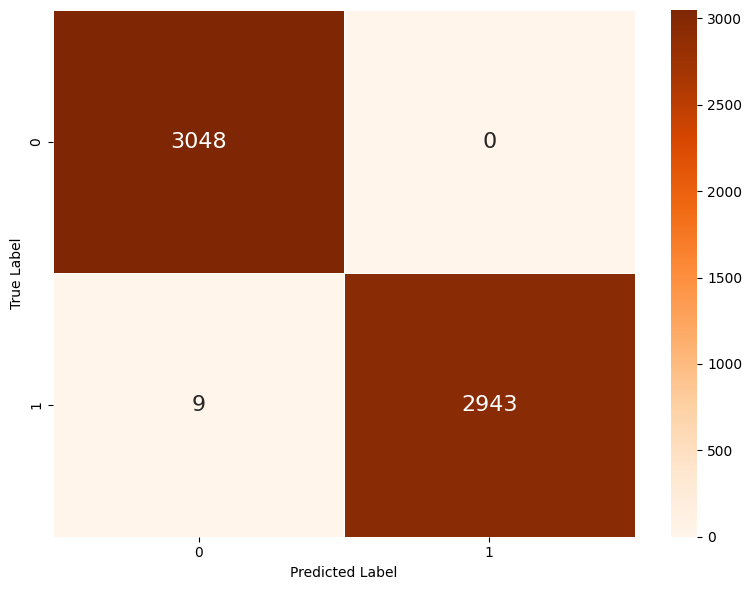

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', linewidths=0.5, annot_kws={"size": 16})
#plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("cm_cnn.png", dpi=600, bbox_inches='tight')
plt.show()